## Setup

In [17]:
from datetime import datetime
import os, importlib

from functools import partial

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


crop_shape = (64, 64, 1)
image_shape = (64, 64, 1)

params = {
        'thr': 0.2, #seed pixel magnitude 
        'size_thr': 10 #number of pixels in patch
        }

## Use mixed precision policy: 32 bits for data, 16 bits for weights to profit from TensorCores

In [2]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


## TF 2.4.1 with CUDA 11 requires setting the memor growth to True 

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Start the Tensorboard server. I it more convenient to open it i a new browser tab with http://localhost:8008/ and clear the output of this cell.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit --port=8008 --bind_all

## Test data manipulation functions 

ROI: (101,18) - (127,39)


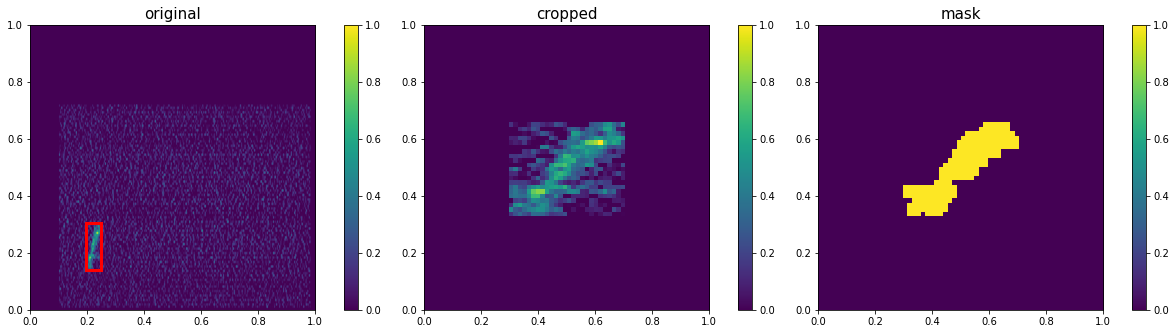

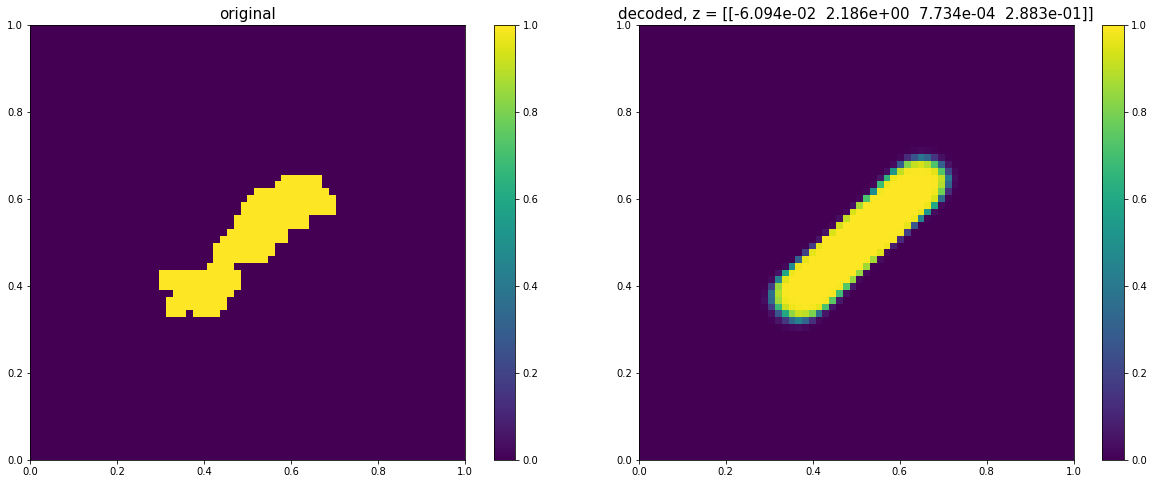

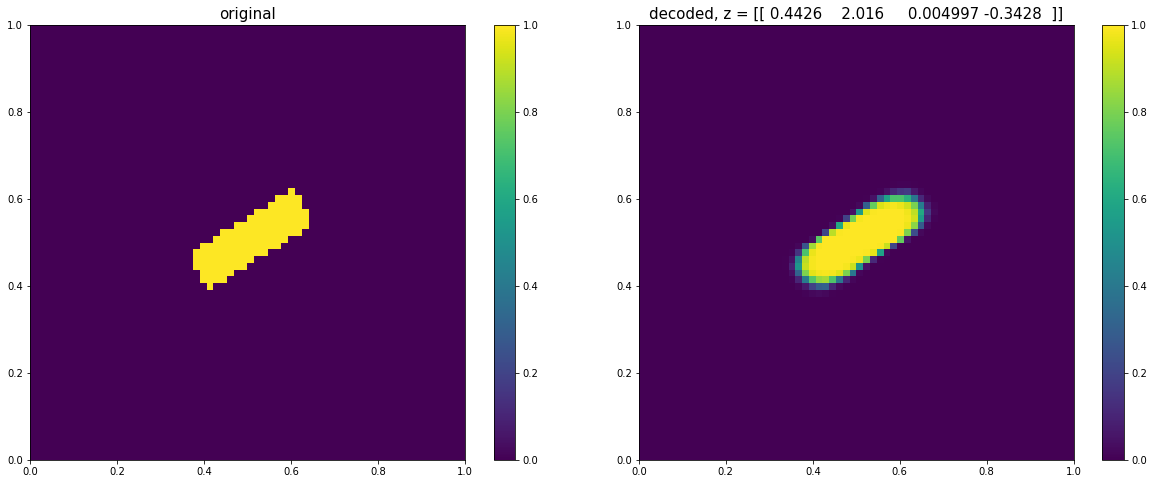

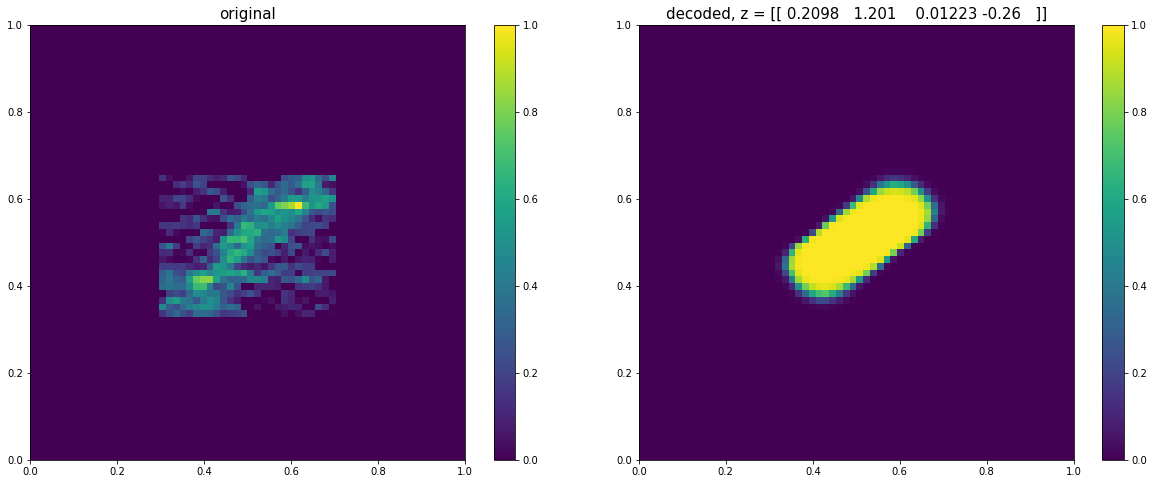

In [138]:
import io_functions as iof
importlib.reload(iof)

import plotting_functions as plf
importlib.reload(plf)

fileNames = ["UVWProjections_2018-06-19T15:13:33.941_0008.tfrecords"]
dataset = iof.readTFRecordFile(fileNames)
dataset = dataset.map(lambda item: iof.preprocessProjections(item, projection=2))

for data in dataset.take(1):
    rois = iof.find_ROIs(data, **params)
    if not len(rois):
        continue
    cropped, mask = iof.crop_ROI(data, rois[0], shape=(64,64))  
    plf.plotOriginal_vs_cropped(data, cropped, mask, rois[0])
    mask = tf.reshape(mask, (1,)+mask.shape)
    plf.plotOriginal_vs_decoded(mask, vae)
    
      
shapes_dataset = tf.data.Dataset.from_generator(iof.shapes_images_generator, (tf.bool))  
shapes_dataset = shapes_dataset.batch(1)
for data in shapes_dataset.take(1):
    plf.plotOriginal_vs_decoded(data, vae)
        
generator = partial(iof.cropped_images_generator, dataset)  
cropped_dataset = tf.data.Dataset.from_generator(generator, (tf.float32))  
cropped_dataset = cropped_dataset.batch(1)
for data in cropped_dataset.take(1):
    plf.plotOriginal_vs_decoded(data, vae)

## Build the encoder, bottleneck and decoder

In [25]:
#########################
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
#########################
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim), dtype=tf.dtypes.float16)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
#########################   
def getEncoder(filters, fc_size, latent_dim):
    encoder_inputs = keras.Input(shape=image_shape)
    x = encoder_inputs
    #x = data_augmentation(encoder_inputs)

    for nFilters in filters:
        x = layers.Conv2D(filters=nFilters, kernel_size=3, activation="relu", strides=2, padding="same")(x)

    endcoder_outputs = x 
    x = layers.Flatten()(x)
    x = layers.Dense(fc_size, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    print("Encoder input shape:",encoder_inputs.shape)
    print("Encoder output shape:",endcoder_outputs.shape)
    print("Latent dimension:",z.shape)
    return encoder, endcoder_outputs.shape[1:]
########################
########################
def getDecoder(filters, fc_size, latent_dim, encoder_shape):
    decoder_inputs = keras.Input(shape=(latent_dim))
    x = layers.Dense(np.prod(encoder_shape), activation="relu")(decoder_inputs)
    x = layers.Reshape(encoder_shape)(x)
    for nFilters in np.flip(filters, axis=[0]):
        x = layers.Conv2DTranspose(filters=nFilters, kernel_size=3, activation="relu", strides=2, padding="same")(x)

    decoder_outputs = layers.Conv2D(filters=1, kernel_size=1, activation="sigmoid", strides=1, padding="same")(x)
    decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
    print("Decoder output shape:",decoder_outputs.shape)
    return decoder
########################
########################  

## Test endocer/decoder creation

In [ ]:
latent_dim = 2
fc_size = 256
filters = np.array([32, 32, 64, 64])
encoder, encoder_shape = getEncoder(filters, fc_size, latent_dim)
decoder = getDecoder(np.flip(filters, axis=[0]), fc_size, latent_dim, encoder_shape)

tf.keras.utils.plot_model(encoder, 'fig_png/encoder_arch.png', show_shapes=True)
tf.keras.utils.plot_model(decoder, 'fig_png/decoder_arch.png', show_shapes=True)

## Define the VAE as a `Model` with a custom `train_step`

In [91]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        for key, value in kwargs.items():
            print("{0} = {1}".format(key, value))
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def evaluation(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z_mean)
        reconstruction_loss = keras.losses.BinaryCrossentropy()(data, reconstruction)
        return {
            "reconstruction_loss": reconstruction_loss
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.losses.BinaryCrossentropy()(data, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.beta*tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
########################  

## Train the VAE

In [213]:
import io_functions as iof
importlib.reload(iof)

generator = iof.shapes_images_generator
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=crop_shape, dtype=tf.bool)))
dataset = dataset.batch(32)
dataset = dataset.cache()

latent_dim = 4
fc_size = 256
filters = np.array([32, 32, 64, 64])
encoder, encoder_shape = getEncoder(filters, fc_size, latent_dim)
decoder = getDecoder(filters, fc_size, latent_dim, encoder_shape)
beta = latent_dim/np.prod(encoder_shape)
vae = VAE(encoder, decoder, beta)

initial_learning_rate = 1E-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                            decay_steps=5000,
                                                            decay_rate=0.95,
                                                            staircase=True)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=(2,10))

current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training start. Current Time =", current_time)

nEpochs = 20
vae.fit(dataset, epochs=nEpochs,
        verbose=1,  
        use_multiprocessing=True,   
        callbacks=[tensorboard_callback]
        )

current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
tag = "{epoch:04d}_"+datetime.now().strftime("%b_%d_%Y_%H_%M")
iof.saveVAE(vae, tag.format(epoch=nEpochs))
print("Training end. Current Time =", current_time)

Encoder input shape: (None, 64, 64, 1)
Encoder output shape: (None, 4, 4, 64)
Latent dimension: (None, 4)
Decoder output shape: (None, 64, 64, 1)
Training start. Current Time = Jun 29 2021 10:58:06
Epoch 1/20
1000/1000 [==============================] - 41s 40ms/step - loss: 0.3813 - reconstruction_loss: 0.2120 - kl_loss: 0.0185
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0818 - reconstruction_loss: 0.0441 - kl_loss: 0.0305
Epoch 3/20
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0659 - reconstruction_loss: 0.0331 - kl_loss: 0.0316
Epoch 4/20
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0625 - reconstruction_loss: 0.0302 - kl_loss: 0.0317
Epoch 5/20
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0606 - reconstruction_loss: 0.0286 - kl_loss: 0.0316
Epoch 6/20
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0591 - reconstruction_loss: 0.0272 - kl_loss: 0.0315
Epoch 7/20
100

## Display original and decoded images from fake dataset

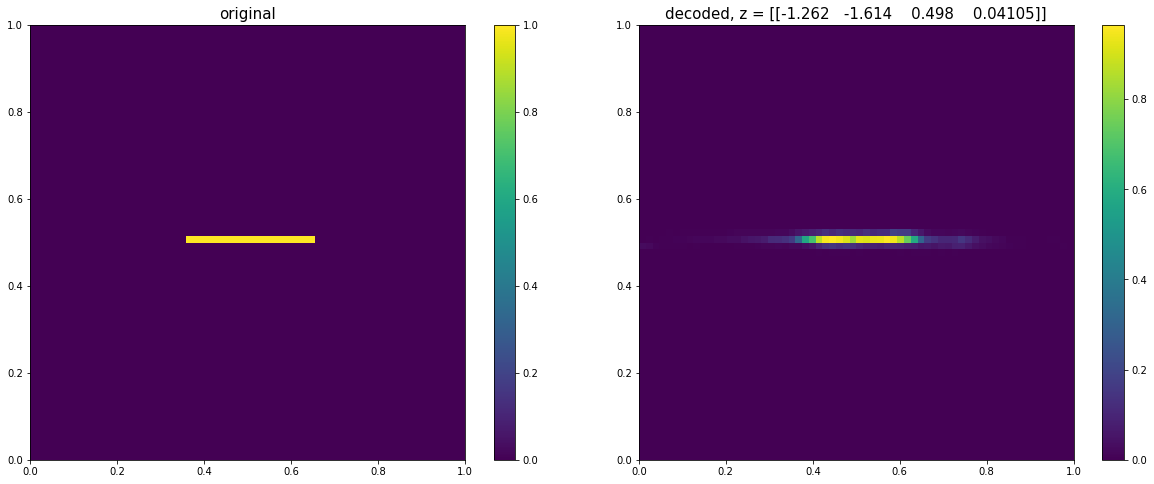

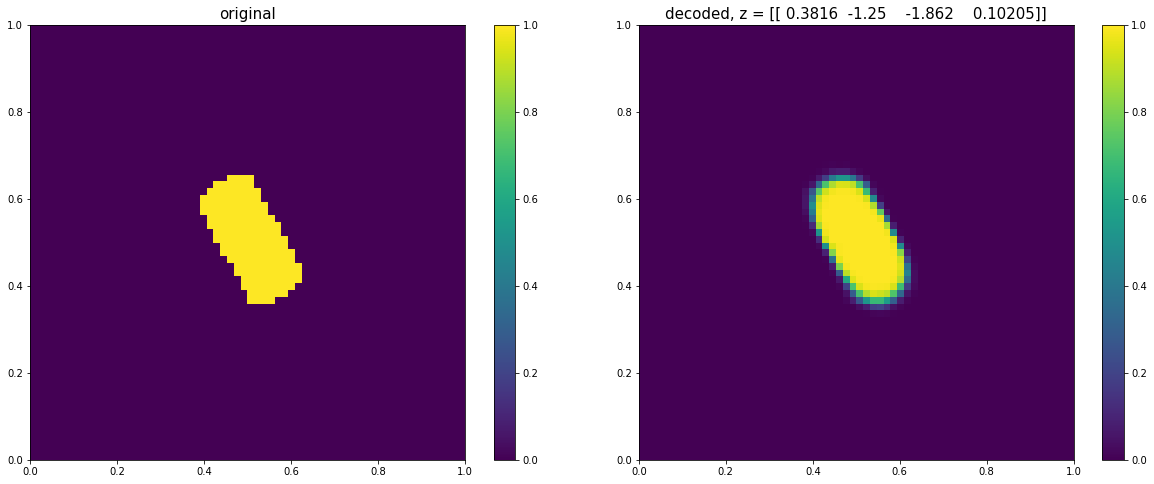

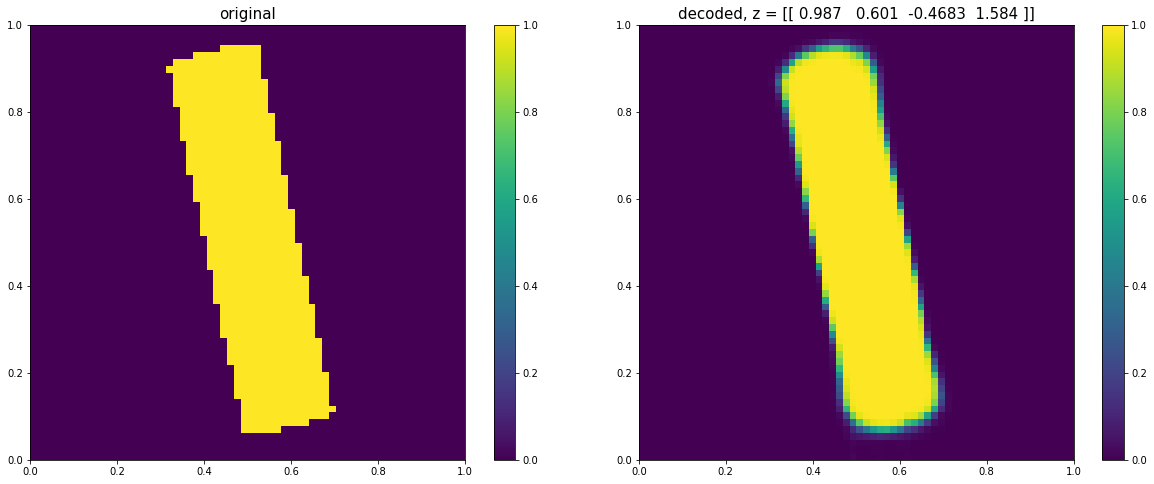

In [214]:
import io_functions as iof
importlib.reload(iof)

import plotting_functions as plf
importlib.reload(plf)

generator = iof.shapes_images_generator
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=image_shape, dtype=tf.bool)))
dataset = dataset.batch(1)

for data in dataset.take(3):
    plf.plotOriginal_vs_decoded(data, vae)

## Collect loss for the entire dataset and put into Pandas DataFrame for further analysis.
## Display example original and decoded images from ELITPC dataset

          loss
0     0.070251
1     0.055481
2     0.104431
3     0.017609
4     0.010551
...        ...
1922  0.010551
1923  0.123840
1924  0.010551
1925  0.010330
1926  0.892090

[1927 rows x 1 columns]


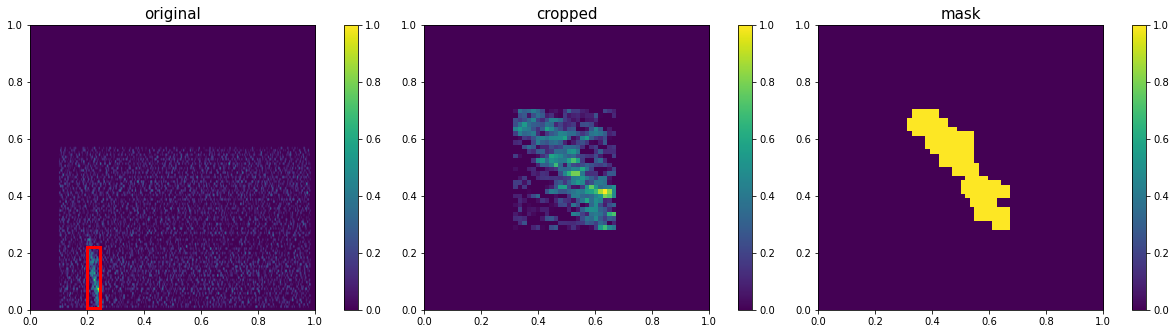

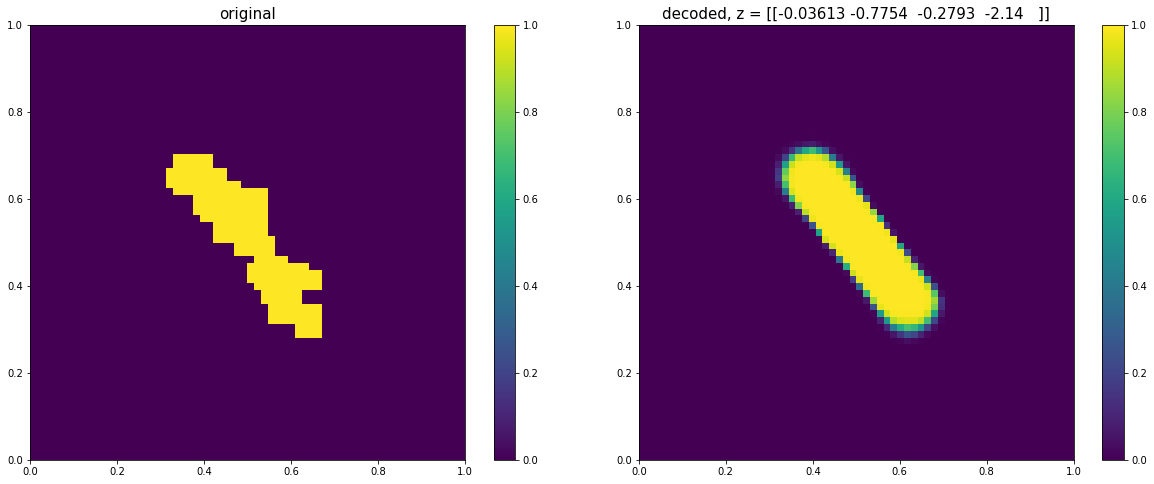

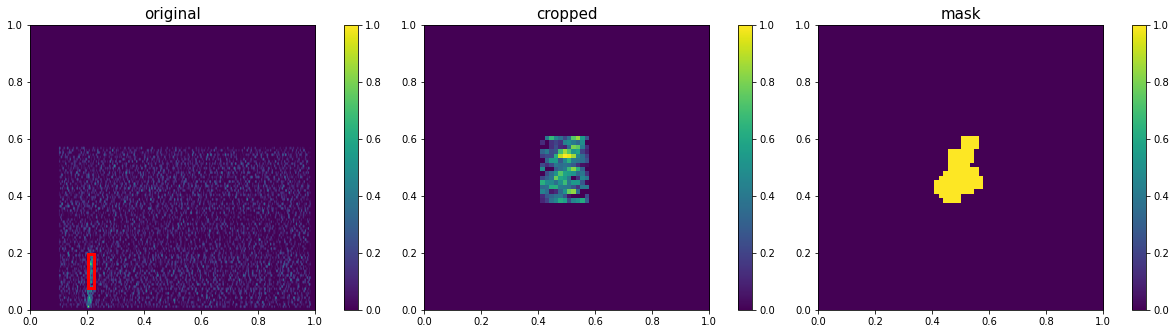

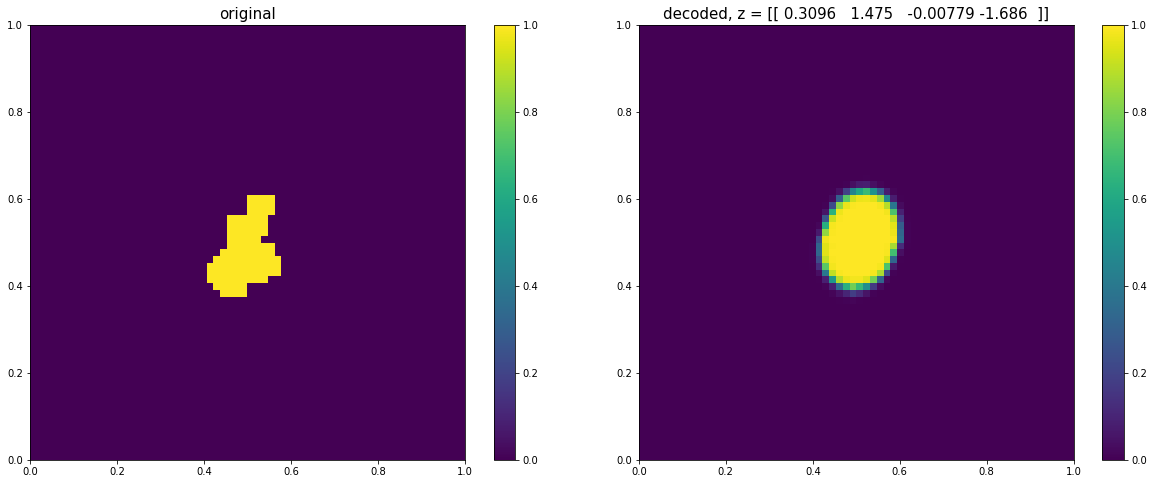

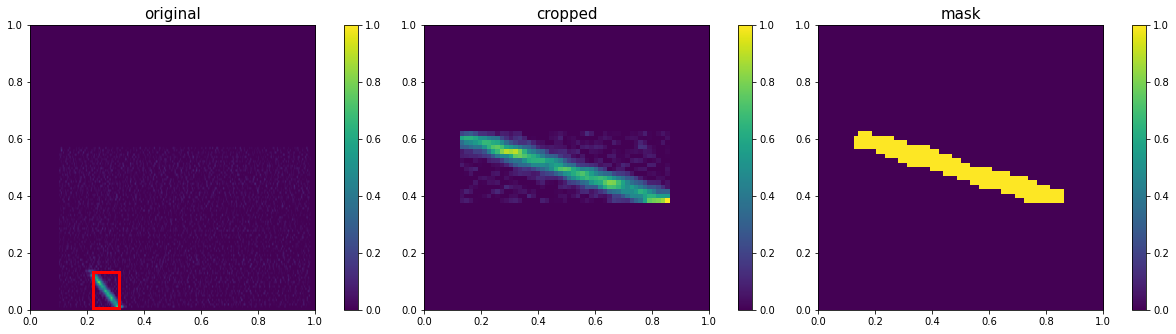

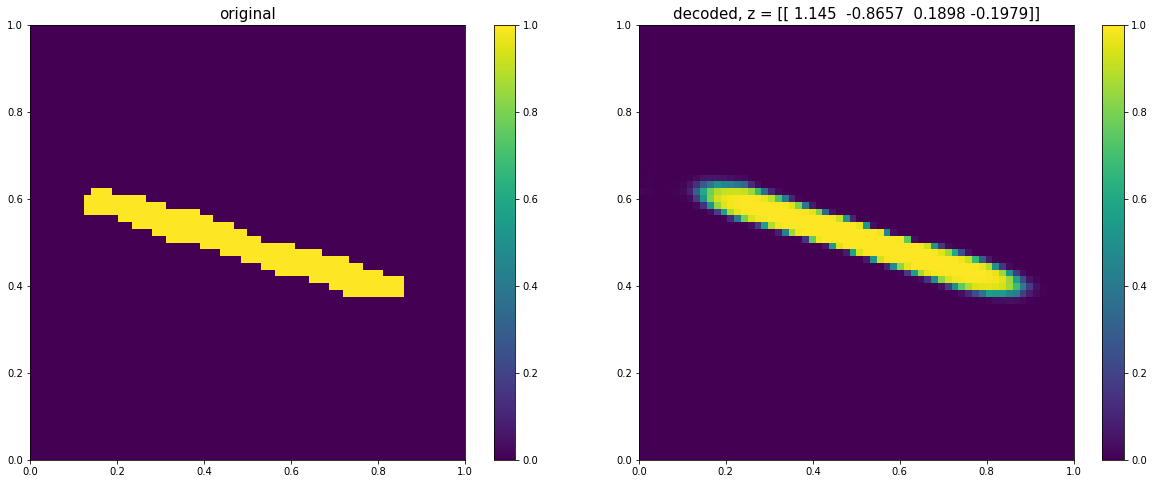

In [220]:
import io_functions as iof
importlib.reload(iof)

import plotting_functions as plf
importlib.reload(plf)

fileNames = ["UVWProjections_2018-06-19T15:13:33.941_0008.tfrecords"]
dataset = iof.readTFRecordFile(fileNames)
dataset = dataset.map(lambda item: iof.preprocessProjections(item, projection=0))

tag = "0020_Jun_28_2021_15_55"
encoder, decoder = iof.loadEncoderDecoder(tag)
vae = VAE(encoder, decoder, 1.0)
df = pd.DataFrame(columns=["loss"])

index = 0
    
for data in dataset:
    
    rois = iof.find_ROIs(data, **params)
    if not len(rois):
        roi = None
    else:
        roi = rois[0]
    cropped, mask = iof.crop_ROI(data, roi, shape=(64,64))  
    mask_batched = tf.reshape(mask, (1,)+mask.shape)
    
    if index<3:
        plf.plotOriginal_vs_cropped(data, cropped, mask, rois[0])
        plf.plotOriginal_vs_decoded(mask_batched, vae)
    
    loss = vae.evaluation(mask_batched)
    batch_df = pd.DataFrame(data={"loss":np.array(loss["reconstruction_loss"])}, index=[index])
    df = pd.concat([df, batch_df])
    index += 1
    
print(df)    

## Plot loss distribution and select outliers

          loss
870   1.554688
1442  2.437500
1470  1.651367
loss tf.Tensor(1.555, shape=(), dtype=float16)
loss tf.Tensor(2.438, shape=(), dtype=float16)
loss tf.Tensor(1.651, shape=(), dtype=float16)


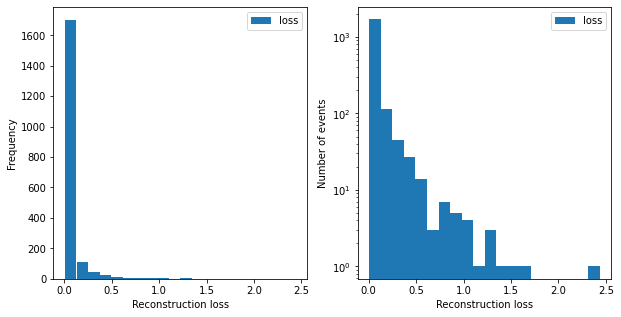

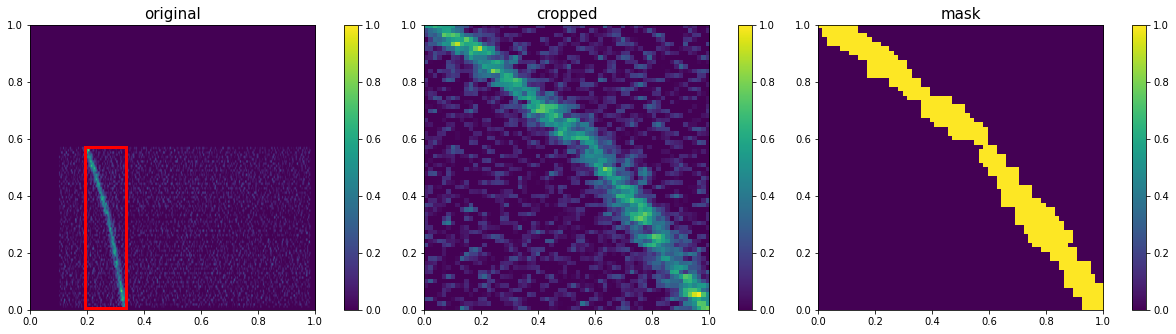

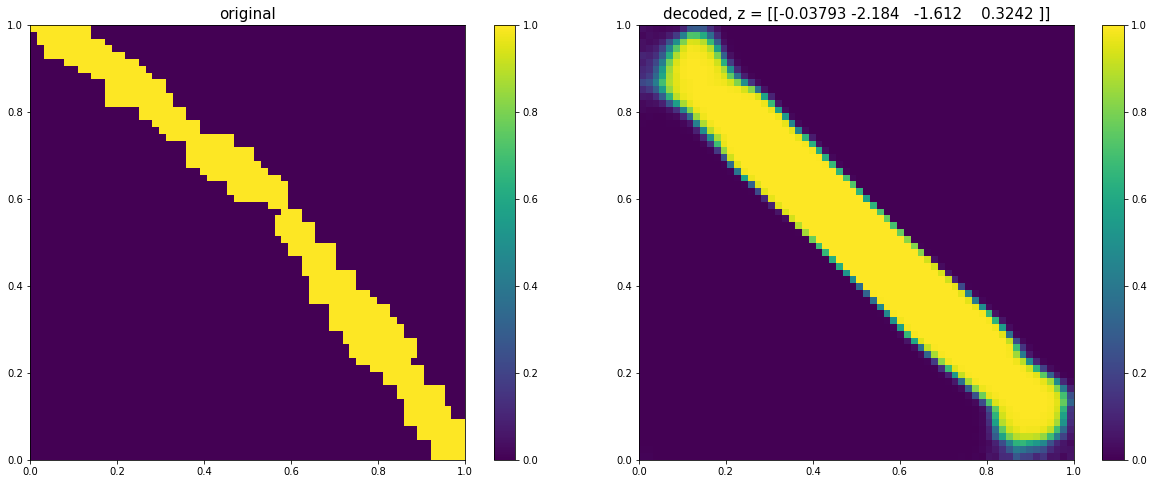

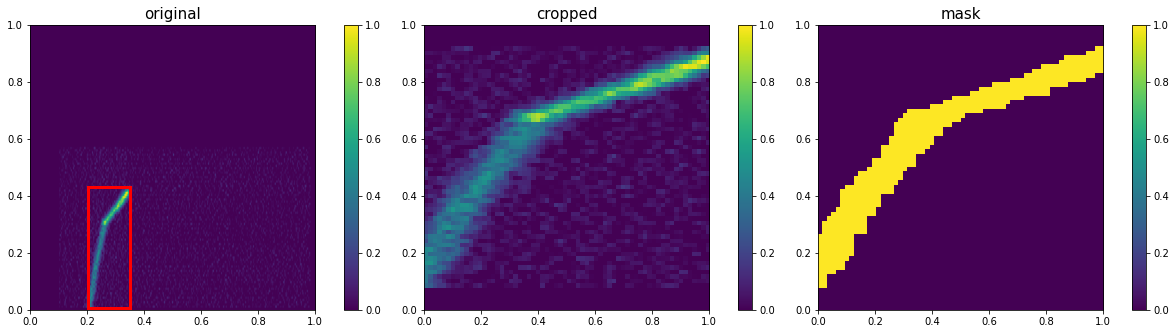

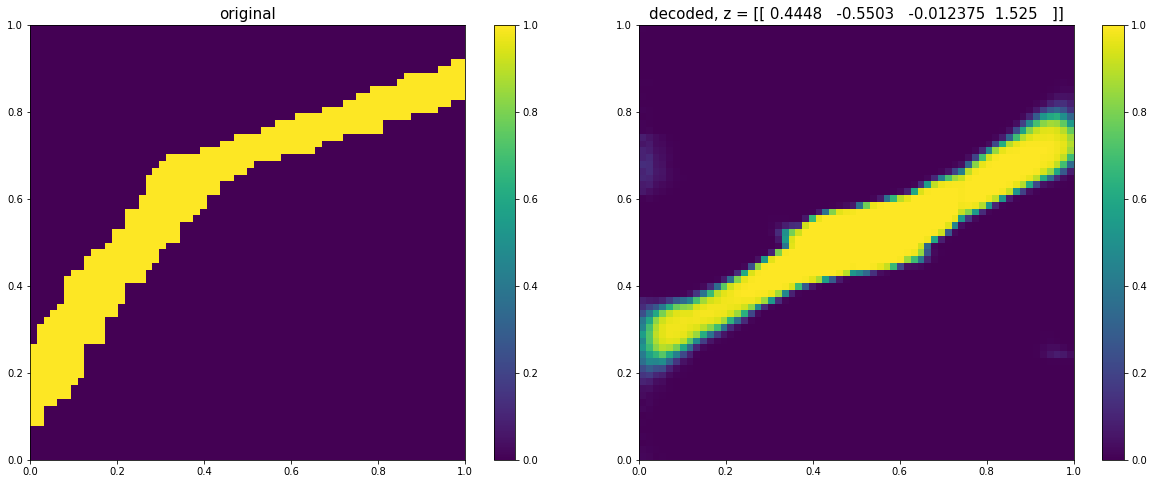

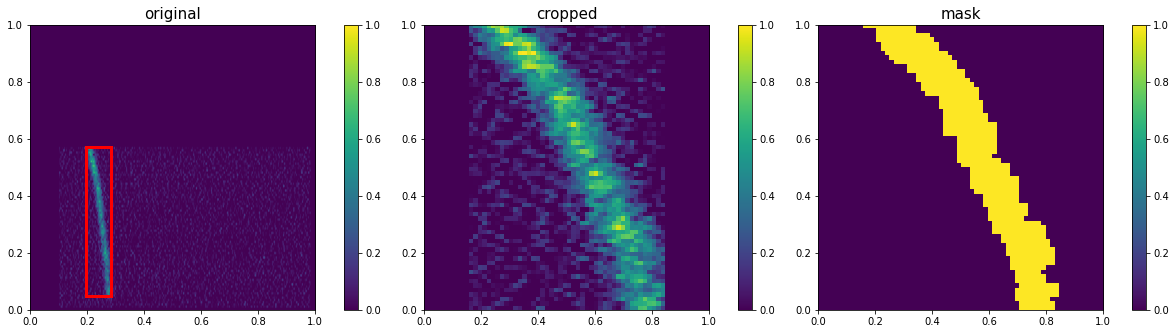

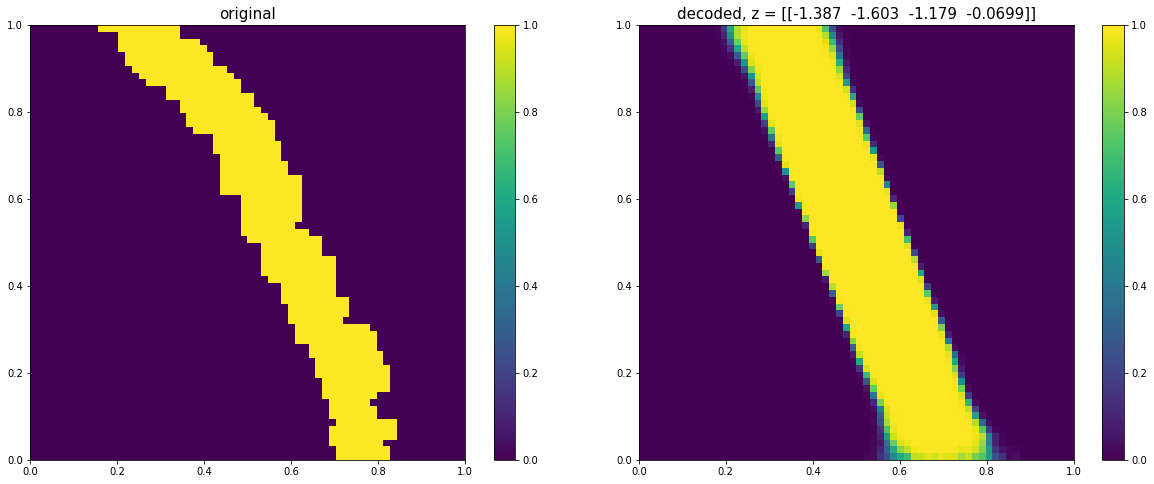

In [221]:
import plotting_functions as plf
importlib.reload(plf)

plf.plotLoss(df)

df_filtered = df[df["loss"]>1.5]
events = df_filtered.index
print(df_filtered)                 

fileNames = ["UVWProjections_2018-06-19T15:13:33.941_0008.tfrecords"]
dataset = iof.readTFRecordFile(fileNames)
dataset = dataset.map(lambda item: iof.preprocessProjections(item, projection=0))
dataset = dataset.enumerate()

#events = (636) #The three tracks event

for index, data in dataset:
    
    if not np.isin(index,events):
        continue
                  
    rois = iof.find_ROIs(data, **params)
    if not len(rois):
        roi = None
        continue
    else:
        roi = rois[0]
    cropped, mask = iof.crop_ROI(data, roi, shape=(64,64))  
    
    plf.plotOriginal_vs_cropped(data, cropped, mask, roi)
    mask = tf.reshape(mask, (1,)+mask.shape)
    plf.plotOriginal_vs_decoded(mask, vae)
    loss = vae.evaluation(mask)
    print("loss",loss["reconstruction_loss"])

## Display a grid of sampled images (works only for dim=2  latent space)

In [ ]:
import plotting_functions as plf
importlib.reload(plf)

plf.plot_latent_space(vae)

## Generate sample image (works only for dim=2  latent space)

In [ ]:
def generate_image(vae, z1, z2):
    figure = np.zeros(image_shape[:-1])
    z_sample = np.array([[z1, z2]])
    figure = vae.decoder.predict(z_sample)
    figure = np.reshape(figure, image_shape[:-1])
    figure = tf.cast(10*figure, dtype=tf.int64)
    result = np.stack((figure, figure, figure), axis=0)
    return result    
#####################################################
#####################################################
def plotEvent(eventRow, prediction = None, groundTruth = None):
    f, ax = plt.subplots(1,3, figsize=(20,8))
    if prediction is None:
        ax[0].set_title('U', fontsize = 15)
        ax[1].set_title('V', fontsize = 15)
        ax[2].set_title('W', fontsize = 15)        
    else:
        ax[0].set_title('U \nprediction: {}\nground truth {}'. format(prediction,groundTruth), fontsize = 15)
        ax[1].set_title('V \nprediction: {}\nground truth {}'. format(prediction,groundTruth), fontsize = 15)
        ax[2].set_title('W \nprediction: {}\nground truth {}'. format(prediction,groundTruth), fontsize = 15)

        
    imageRange = [0,1, 0,1]
    ax[0].imshow(np.transpose(eventRow[0,:,:]) ,extent=imageRange, origin='lower')
    ax[1].imshow(np.transpose(eventRow[1,:,:]) ,extent=imageRange, origin='lower')
    ax[2].imshow(np.transpose(eventRow[2,:,:]) ,extent=imageRange, origin='lower')   
    
    
generatedRow = generate_image(vae, z1=-0.5, z2=0.5)
plotEvent(eventRow=generatedRow)

## Display how the latent space clusters different digit classes ()

In [ ]:
##############################################
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    ax = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    circle = plt.Circle((0.25, 0), radius=1.7, color='r', fill=False)
    plt.gca().add_patch(circle)
##############################################

fileNames = ["UVWProjections_2018-06-19T15:13:33.941_0008.tfrecords"]
dataset = readTFRecordFile(fileNames)
dataset = dataset.map(lambda item: preprocessProjections(item))
#generator = partial(cropped_images_generator, dataset) 
generator = shapes_images_generator
dataset = tf.data.Dataset.from_generator(generator, (tf.bool))
dataset = dataset.batch(1000)

for item in dataset.take(1):
    plot_label_clusters(vae, item, labels = tf.zeros((1000)))  